In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('data/cs-training.csv', index_col=0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
import pandas_profiling

data.sample(n=20000).profile_report(style={'full_width':True})

In [7]:
data.count()

SeriousDlqin2yrs                        150000
RevolvingUtilizationOfUnsecuredLines    150000
age                                     150000
NumberOfTime30-59DaysPastDueNotWorse    150000
DebtRatio                               150000
MonthlyIncome                           120269
NumberOfOpenCreditLinesAndLoans         150000
NumberOfTimes90DaysLate                 150000
NumberRealEstateLoansOrLines            150000
NumberOfTime60-89DaysPastDueNotWorse    150000
NumberOfDependents                      146076
dtype: int64

In [38]:
data.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [101]:
data[data.NumberRealEstateLoansOrLines> 10] = 10

In [102]:
def weight_of_evidence(df, labelcol, col, categorical_col=None):
    if categorical_col is None:
        categorical_col = col
    
    tempdf = data.groupby(by=categorical_col).agg({labelcol:{
                                                        '_counts': 'size',
                                                        '_bads': lambda x: len(x[x==1]),
                                                        '_goods': lambda x: len(x[x==0])
                                                    }})
    tempdf.columns  = [col+ column for column in tempdf.columns.droplevel(0)]
    tempdf[col+'_distri_tot'] = tempdf[col+'_counts']/(tempdf[col+'_counts'].sum())
    tempdf[col+'_distri_bads'] = tempdf[col+'_bads']/(tempdf[col+'_bads'].sum())
    tempdf[col+'_distri_goods'] = tempdf[col+'_goods']/(tempdf[col+'_goods'].sum())
    tempdf[col+'_bad_rate'] = tempdf[col+'_bads']/tempdf[col+'_counts']
    tempdf[col+'_woe'] = np.log(tempdf[col+'_distri_goods']) - np.log(tempdf[col+'_distri_bads'])
    return tempdf

tempdf = weight_of_evidence(data.dropna(), 'SeriousDlqin2yrs', 'NumberRealEstateLoansOrLines', categorical_col='NumberRealEstateLoansOrLines')
tempdf.head()

,NumberRealEstateLoansOrLines_counts,NumberRealEstateLoansOrLines_bads,NumberRealEstateLoansOrLines_goods,NumberRealEstateLoansOrLines_distri_tot,NumberRealEstateLoansOrLines_distri_bads,NumberRealEstateLoansOrLines_distri_goods,NumberRealEstateLoansOrLines_bad_rate,NumberRealEstateLoansOrLines_woe
NumberRealEstateLoansOrLines,,,,,,,,
0,56188,4672,51516,0.374587,0.466967,0.368232,0.083149,-0.237545
1,52338,2748,49590,0.348920,0.274663,0.354465,0.052505,0.255066
2,31522,1765,29757,0.210147,0.176412,0.212700,0.055993,0.187064
3,6300,422,5878,0.042000,0.042179,0.042015,0.066984,-0.003884
4,2170,194,1976,0.014467,0.019390,0.014124,0.089401,-0.316878


In [103]:
tempdf.NumberRealEstateLoansOrLines_distri_bads

NumberRealEstateLoansOrLines
0     0.466967
1     0.274663
2     0.176412
3     0.042179
4     0.019390
5     0.008296
6     0.004798
7     0.003098
8     0.002299
9     0.001399
10    0.000500
Name: NumberRealEstateLoansOrLines_distri_bads, dtype: float64

In [104]:
def information_value(df, col):
    df['diff_col'] = df[col+'_distri_goods'] - df[col+'_distri_bads']
    return np.sum(df['diff_col']*df[col+'_woe'])

information_value(tempdf, 'NumberRealEstateLoansOrLines')

0.06379775077489441

In [36]:
np.log(tempdf['NumberRealEstateLoansOrLines_distri_bads'])

0    -2.772589
1    -2.772589
2    -2.772589
3    -2.772589
4    -2.772589
5    -2.772589
6    -2.772589
7    -2.772589
8    -2.772589
9    -2.772589
10   -2.772589
11   -2.772589
12   -2.772589
13   -2.772589
14   -2.772589
15   -2.772589
Name: NumberRealEstateLoansOrLines_distri_bads, dtype: float64

In [83]:

x = data.groupby(by='NumberRealEstateLoansOrLines').agg({'SeriousDlqin2yrs':{
                                                        'counts': 'size',
                                                        'bads': lambda x: len(x[x==1]),
                                                        'goods': lambda x: len(x[x==0])
}
                                                    })
x.columns  = ['NumberRealEstateLoansOrLines_'+ col for col in x.columns.droplevel(0)]
x

,NumberRealEstateLoansOrLines_counts,NumberRealEstateLoansOrLines_bads,NumberRealEstateLoansOrLines_goods
NumberRealEstateLoansOrLines,,,
0,56188,4672,51516
1,52338,2748,49590
2,31522,1765,29757
3,6300,422,5878
4,2170,194,1976
5,689,83,606
6,320,48,272
7,171,31,140
8,93,23,70


## Clipping, Missing Values and Binning

In [112]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

### SeriousDlqin2yrs

In [117]:
# clip serious delinquency in 2 years to 10

data.SeriousDlqin2yrs.value_counts()

0     139901
1      10005
10        94
Name: SeriousDlqin2yrs, dtype: int64

### RevolvingUtilizationOfUnsecuredLines

In [118]:
data.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.054530
std         249.755348
min           0.000000
25%           0.029896
50%           0.154479
75%           0.560458
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

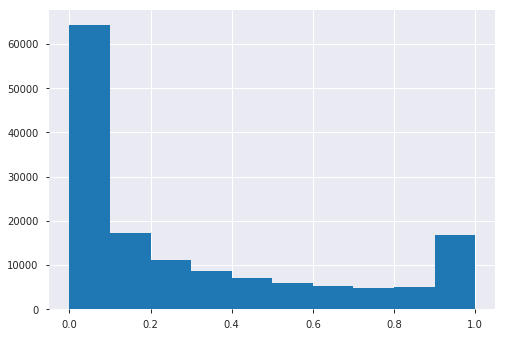

In [121]:
# clip RevolvingUtilizationOfUnsecuredLines to 1 

data[data.RevolvingUtilizationOfUnsecuredLines<=1].RevolvingUtilizationOfUnsecuredLines.hist()

### Debt Ratio

In [107]:
# clip debt ratio to 1

data.DebtRatio.describe()

count    150000.000000
mean        351.565722
std        2029.570808
min           0.000000
25%           0.175074
50%           0.366526
75%           0.870360
max      329664.000000
Name: DebtRatio, dtype: float64

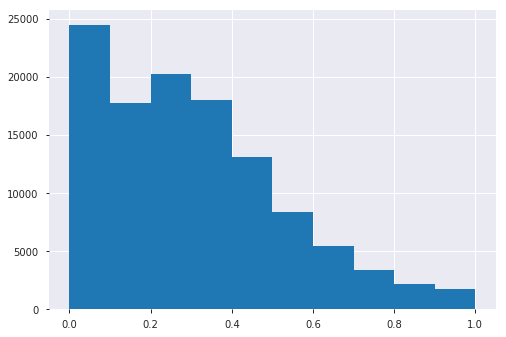

In [111]:
# create bins from debt_ratio
data[data.DebtRatio<=1].DebtRatio.hist(bins=10)

### Age

In [113]:
data.age.describe()

count    150000.000000
mean         52.267060
std          14.806589
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

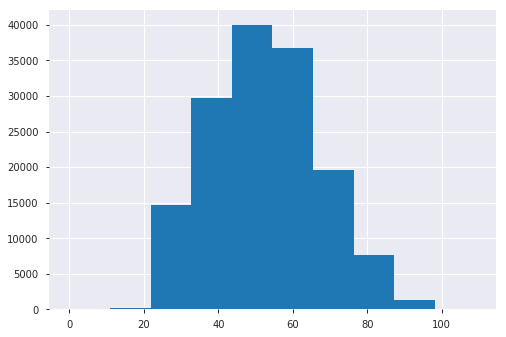

In [114]:
# clip age below 21

data.age.hist()

### NumberOfTime30-59DaysPastDueNotWorse

In [122]:
data['NumberOfTime30-59DaysPastDueNotWorse'].describe()

count    150000.000000
mean          0.426913
std           4.199499
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

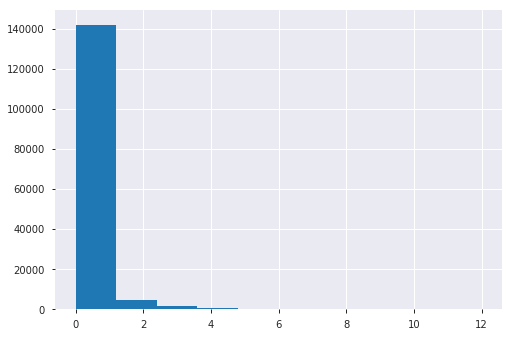

In [144]:
# clip NumberOfTime30-59DaysPastDueNotWorse when > 10

data[data['NumberOfTime30-59DaysPastDueNotWorse']<=12]['NumberOfTime30-59DaysPastDueNotWorse'].hist()

In [142]:
data['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     125953
1      16015
2       4593
3       1754
4        744
5        341
98       264
6        139
10        98
7         53
8         25
9         12
96         5
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

### NumberOfTime60-89DaysPastDueNotWorse

In [158]:
data['NumberOfTime60-89DaysPastDueNotWorse'].describe()

count    150000.000000
mean          0.246573
std           4.162292
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

In [ ]:
da

### MonthlyIncome

In [146]:
# handle missing values
data.MonthlyIncome.describe()

count    1.202830e+05
mean     6.653350e+03
std      1.434211e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.224500e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

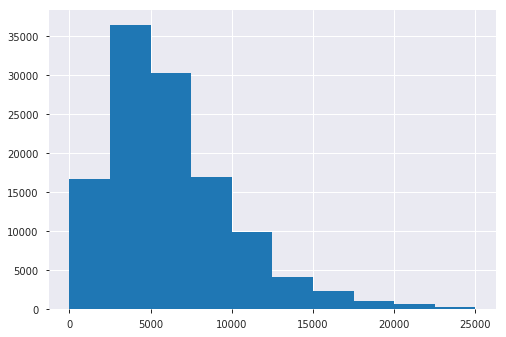

In [150]:
# clip large values

data[data.MonthlyIncome < data.MonthlyIncome.quantile(0.99)].MonthlyIncome.hist()

In [151]:
# handle zero income groups

data[data.MonthlyIncome==0].shape

(1634, 11)

### NumberOfOpenCreditLinesAndLoans

In [154]:
data['NumberOfOpenCreditLinesAndLoans'].describe()

count    150000.000000
mean          8.443080
std           5.125177
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          57.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

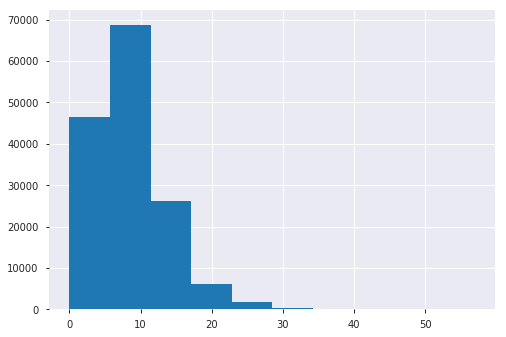

In [157]:
# clip large values > 25

data['NumberOfOpenCreditLinesAndLoans'].hist()

In [156]:
data.NumberOfOpenCreditLinesAndLoans.quantile(0.98)

22.0